In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization:** The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape:** The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [4]:
# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

# Build Generator

### This generator is part of a CGAN that generates images according to the given label.

### It combines random noise with a label to create a specific image class (e.g., generating a "2" when the label is 2).

In [5]:
# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()
build_generator().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 100)         │          1,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100)            │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 100)            │              0 │ input_layer_3[0][0],   │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 28, 28, 1)      │      1,493,520 │ multiply_1[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,494,520 (5.70 MB)

 Trainable params: 1,490,936 (5.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

# Build Discriminator Model

### This model is a discriminator in a CGAN. It takes both an image and a label as input and determines whether the image is real or fake, based on the given label.

### By combining the image and label inputs, the discriminator can ensure that the image corresponds to the specified label before deciding if it's real or fake.

In [6]:
# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

# Build the discriminator and print the summary
discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 784)         │          7,840 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 784)            │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 28, 28, 1)      │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 2)      │              0 │ input_layer_6[0][0],   │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 1)              │        934,913 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 942,753 (3.60 MB)

 Trainable params: 942,753 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

# Build and Compile the Models

### The **discriminator** is compiled with the Adam optimizer and binary cross-entropy loss since it needs to classify whether the input is real or fake (binary classification). The accuracy metric is also tracked.

### The **GAN** model is created by combining the generator and discriminator. It takes random noise and a label as input, generates an image, and then passes that image (along with the label) to the discriminator to check if it's real or fake.

### The GAN is also compiled with binary cross-entropy loss since it still involves distinguishing between real and fake images.

In [7]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the Function

### Two arrays, real and fake, are created to represent the target labels: 1 for real images and 0 for fake images.

### The loop runs for a specified number of epochs, where a random batch of real images and their corresponding labels is selected from the dataset for each iteration.

### **Random noise** is generated and fed into the generator (along with the labels) to create fake images.

### The **discriminator** is trained on both the real images (with label 1) and the generated (fake) images (with label 0). The final loss for the discriminator is the average of the two losses.

### The generator is trained through the GAN by trying to fool the discriminator into thinking the generated images are real. The target labels for this are 1 (real) because the generator is rewarded when it can make the discriminator believe its images are real.

In [8]:
# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)



# Saving Generated Images

### This function generates and saves images at each specified interval. It generates 10 images (for digits 0-9) by feeding random noise and the corresponding labels into the generator.

### The images are rescaled from the range [-1, 1] to [0, 1] for display. A 2x5 grid of images is created and displayed.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 1.130597472190857, acc.: 19.53125%] [G loss: [array(0.9836129, dtype=float32), array(0.9836129, dtype=float32), array(0.375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


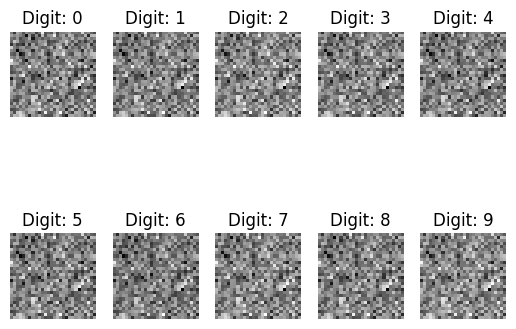

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━

In [9]:
# Function to save generated images
def save_images(epoch):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Generate digits 0-9
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the CGAN
train(epochs=100, batch_size=64, save_interval=1000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


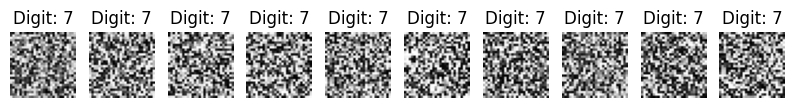

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


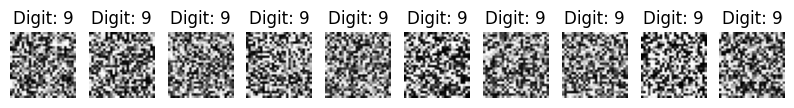

In [10]:
# Generate images for specific digits, e.g., '7' and '9'
def generate_specific_digit_images(digit, num_images=10):
    noise = np.random.normal(0, 1, (num_images, 100))
    labels = np.full((num_images,), digit)  # Create an array of the same digit
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(gen_images[i, :, :, 0], cmap='gray')
        plt.title(f"Digit: {digit}")
        plt.axis('off')
    plt.show()

# Example: Generate 10 images of digit '7'
generate_specific_digit_images(7, num_images=10)

# Example: Generate 10 images of digit '9'
generate_specific_digit_images(9, num_images=10)


# Question 01

## **Modify the CGAN to generate images for specific digits (e.g., generate only '7' or '9').**

---

# Question 02

## **Add label smoothing (e.g., replace real labels of 1 with random values between 0.9 and 1) during training. Analyze how label smoothing affects the training process and the quality of generated images.**

---

# Question 03

## **Generate noise vectors corresponding to two different digits (e.g., '3' and '8'). Perform interpolation between the two noise vectors and visualize how the generated images morph from one digit to the other.**



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
0 [D loss: 2.136477470397949, acc.: 0.38487352430820465%] [G loss: [array(2.1394415, dtype=float32), array(2.1394415, dtype=float32), array(0.00384358, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


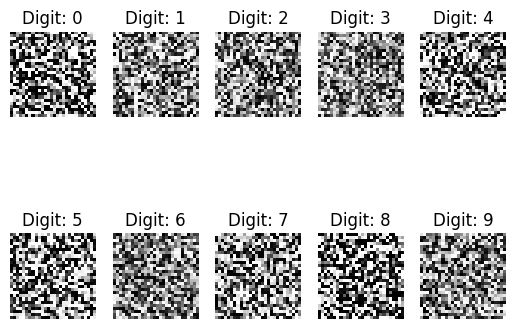

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━

In [13]:
# Modify the training loop to apply label smoothing for real labels
def train_with_label_smoothing(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        # Apply label smoothing: real labels are replaced with values in the range [0.9, 1.0]
        real_smooth = real - 0.1 * np.random.random(real.shape)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_images, labels], real_smooth)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

# Train with label smoothing
train_with_label_smoothing(epochs=100, batch_size=64, save_interval=1000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


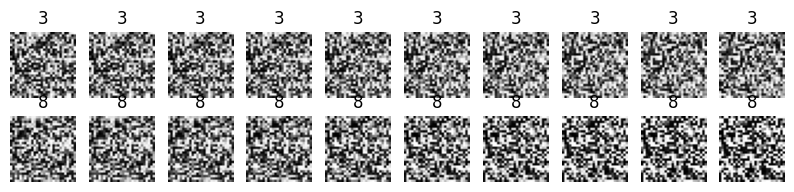

In [14]:
# Function to interpolate between two noise vectors and generate images
def interpolate_between_digits(digit1, digit2, steps=10):
    noise1 = np.random.normal(0, 1, (1, 100))
    noise2 = np.random.normal(0, 1, (1, 100))

    # Create a sequence of labels for the two digits
    labels = np.array([digit1] * steps + [digit2] * steps)

    fig, axs = plt.subplots(2, steps, figsize=(steps, 2))

    for i, t in enumerate(np.linspace(0, 1, steps)):
        interpolated_noise = (1 - t) * noise1 + t * noise2
        generated_image1 = generator.predict([interpolated_noise, np.array([digit1])])
        generated_image2 = generator.predict([interpolated_noise, np.array([digit2])])

        axs[0, i].imshow(0.5 * generated_image1[0, :, :, 0] + 0.5, cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"{digit1}")

        axs[1, i].imshow(0.5 * generated_image2[0, :, :, 0] + 0.5, cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title(f"{digit2}")

    plt.show()

# Example: Interpolate between '3' and '8'
interpolate_between_digits(3, 8, steps=10)
